## Flow Matching - Dummy Data

In [42]:
import math
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, Callback
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

**Flow Matcing Example Using Checker Board**

In [2]:
def make_checker_board(num_sample:int) -> torch.tensor:
    """
    Returns a Checker Board Pattern of dim (num_sample*16, 2)
    """
    dim = 2
    noise1 = torch.FloatTensor(num_sample, dim).uniform_(0.0, 1.0)
    noise2 = torch.FloatTensor(num_sample, dim).uniform_(1.0, 2.0)
    noise3 = torch.FloatTensor(num_sample, dim).uniform_(2.0, 3.0) - torch.tensor([0.0, 2.0])
    noise4 = torch.FloatTensor(num_sample, dim).uniform_(3.0, 4.0) - torch.tensor([0.0, 2.0])

    first_quad = torch.cat((noise1, noise2), dim=0)
    second_quad = first_quad - torch.tensor([2.0, 0.0])
    third_quad = first_quad * torch.tensor([-1.0, -1.0])
    fourth_quad = first_quad - torch.tensor([0.0, 2.0])

    noise = torch.cat((first_quad, second_quad, third_quad, fourth_quad), dim=0)
    return noise

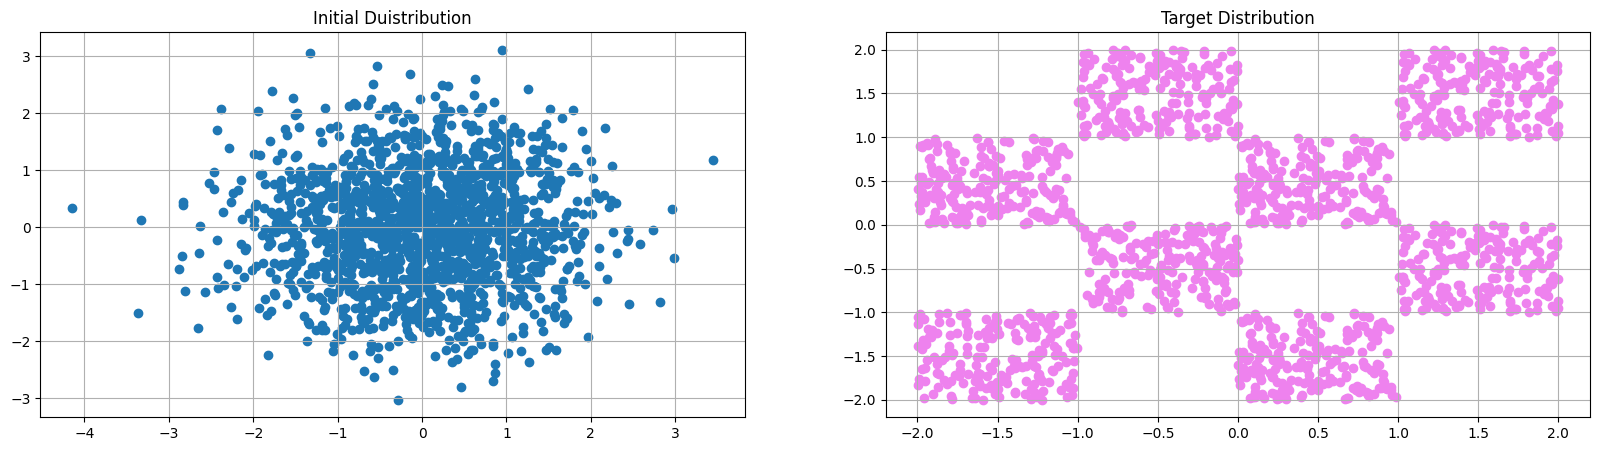

In [ ]:
data_dist = make_checker_board(200)
init_dist = torch.randn_like(data_dist)

plt.figure(figsize=(20, 5))
plt.subplot(1,2,1)
plt.scatter(init_dist[:, 0], init_dist[:, 1])
plt.title("Initial Duistribution")
plt.grid(True)

plt.subplot(1,2,2)
plt.scatter(data_dist[:, 0], data_dist[:, 1], c='violet')
plt.title("Target Distribution")

plt.grid(True)
plt.show()

In [ ]:
init_dist.shape, data_dist.shape

(torch.Size([1600, 2]), torch.Size([1600, 2]))

**Simple Neural Network Model**

In [ ]:
class FlowMatchingModel(nn.Module):
    def __init__(self, input_dim:int = 2):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_dim+1, 16), nn.ReLU(),
            nn.Linear(16, 32), nn.ReLU(),
            nn.Linear(32, 64), nn.ReLU(),
            nn.Linear(64, 128), nn.ReLU(),
            nn.Linear(128, 256), nn.ReLU(),
            nn.Linear(256, 512), nn.ReLU(),
            nn.Linear(512, 256), nn.ReLU(),
            nn.Linear(256, 128), nn.ReLU(),
            nn.Linear(128, 64), nn.ReLU(),
            nn.Linear(64, 32), nn.ReLU(),
            nn.Linear(32, 16), nn.ReLU(),
            nn.Linear(16, 2)
        )


    def forward(self, x:torch.tensor, t:torch.tensor):
        x = torch.cat((x, t), dim=-1)
        return self.layer(x)

    def step(self, x_t:torch.tensor, t:torch.tensor, dt:torch.tensor):
        time_delta = dt/2
        mid_u_t = self(x_t, t)
        mid_x_t = x_t + mid_u_t * time_delta
        u_t = self(mid_x_t, t+time_delta)
        x_t = mid_x_t + u_t * time_delta
        return x_t

    @torch.no_grad
    def sample(self, x_0:torch.tensor, num_step:int):
        self.prob_paths = []
        self.time = []
        x_t = x_0
        time_steps = torch.linspace(0.0, 1.0, num_step).to(device)
        self.prob_paths.append(x_0.detach().cpu().numpy())
        self.time.append(0.0)

        for i in range(len(time_steps)-1):
            dt = time_steps[i+1] - time_steps[i]
            t = torch.full((x_t.shape[0], 1), time_steps[i]).to(device)
            x_t = self.step(x_t, t, dt)
            self.prob_paths.append(x_t.detach().cpu().numpy())
            self.time.append(time_steps[i+1])
        return x_t

**Training Flow Model**

In [ ]:

model = FlowMatchingModel().to(device=device)
Loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.5)

In [ ]:
# epochs = 3000
# for epoch in range(epochs):
#     target = make_checker_board(300).to(device)
#     noise = torch.randn_like(target)
#     t = torch.rand(target.shape[0], 1).to(device)

#     xt = ( 1- t) * noise + t * target
#     output = model(xt, t)

#     loss = Loss(output, target-noise)
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
    # scheduler.step()
    # print(f"epoch : {epoch+1}/{epochs}: Loss : {loss.item()}")

# target = torch.tensor(make_moons(1000, noise=0.05, shuffle=True)[0], dtype=torch.float32).to(device)


In [ ]:
# num_steps = 20
# x_0 = torch.randn(2000, 2).to(device)
# x_1 = model.sample(x_0, num_steps)

# plt.figure(figsize=(15, 5))
# plt.subplot(1,2,1)
# plt.scatter(x_0[:, 0].detach().cpu().numpy(), x_0[:, 1].detach().cpu().numpy())
# plt.grid(True)
# plt.title("Gaussian Distribution")

# plt.subplot(1,2,2)
# plt.scatter(x_1[:, 0].detach().cpu().numpy(), x_1[:, 1].detach().cpu().numpy())
# plt.grid(True)
# plt.title("Predicted Data Distribution")

In [ ]:
# Row, Col = 4, 4
# fig, axes = plt.subplots(Row, Col, figsize=(20, 20))
# indexes = torch.linspace(0, num_steps-1, Row*Col, dtype=torch.int32)

# for i in range(len(indexes)):
#     row = i // Row
#     col = i % Col
#     index = indexes[i]

#     axes[row, col].scatter(model.prob_paths[index][:, 0], model.prob_paths[index][:, 1])
#     axes[row, col].grid(True)
#     axes[row, col].set_title(f"Time Step {model.time[index]}")

# plt.tight_layout()
# plt.show()

## Flow Matching - MNIST DATA (Unguided)

In [43]:
import numpy as np

In [ ]:
# data = np.load('../data/Images(28x28).npy')
data = np.load('../data/Images(500x500)-001.npy')
label = np.load('../data/WriterInfo.npy')
data.shape, label.shape

((13580, 500, 500), (13580, 9))

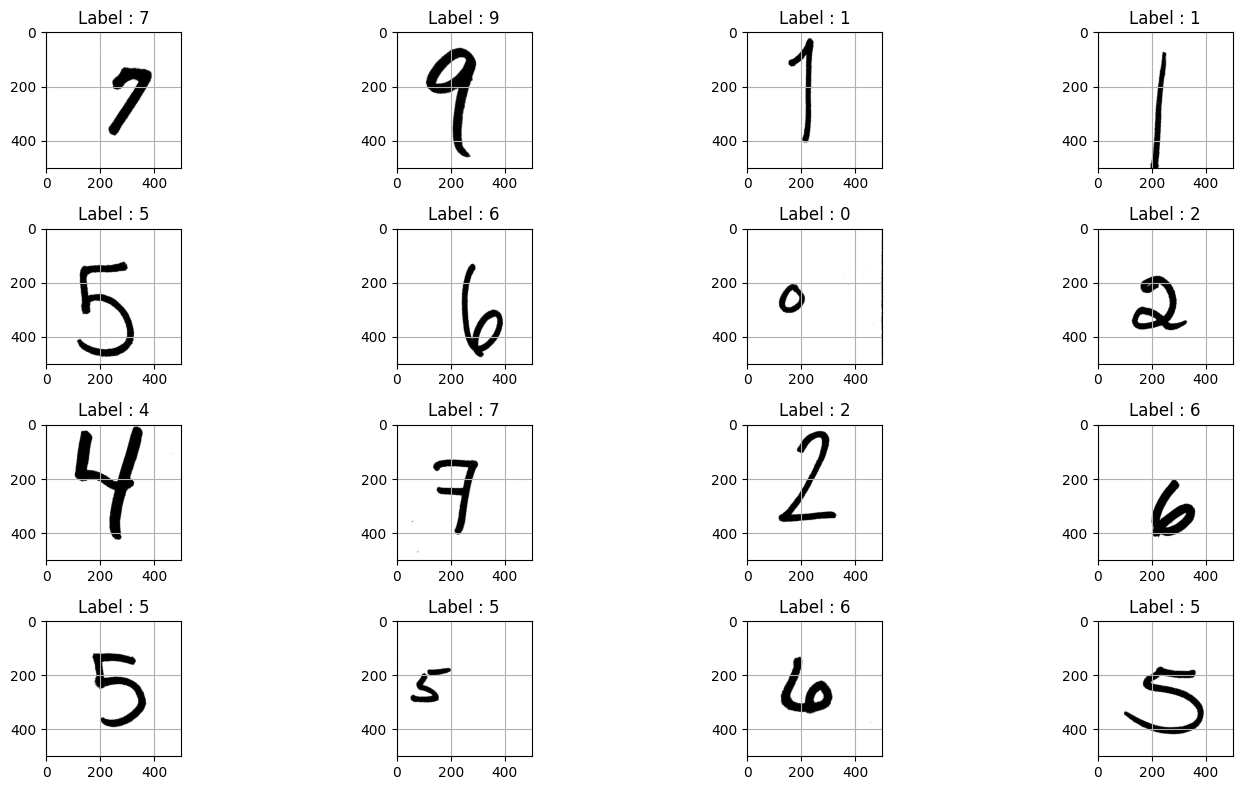

In [ ]:
Row, Col = 4, 4
fig, axes = plt.subplots(Row, Col, figsize=(15, 8))

for i in range(Row*Col):
    index = np.random.randint(0, data.shape[0])
    row_idx = i // Col
    col_idx = i % Col

    axes[row_idx, col_idx].imshow(data[index], cmap='gray')
    axes[row_idx, col_idx].set_title(f"Label : {label[index][0]}")
    axes[row_idx, col_idx].grid(True)

plt.tight_layout()
plt.show()

## Data Loader

In [4]:
import cv2
import os
from torch.utils.data import Dataset, DataLoader

In [5]:
class MNISTData(Dataset):
    def __init__(self, file_path:str, label_path:str, h:int, w:int):
        super().__init__()

        if not os.path.exists(file_path):
            raise FileNotFoundError(f"File does not exists at : {file_path}")
        if not os.path.exists(label_path):
            raise FileNotFoundError(f"File does not exists at : {label_path}")
        
        self.data = np.load(file_path)
        self.label = np.load(label_path)
        self.height = h
        self.width = w
    
    def __len__(self):
        return len(self.label)


    def __getitem__(self, index):
        label = torch.tensor(self.label[index][0], dtype=torch.int64)
        image = cv2.resize(self.data[index], (self.height, self.width), cv2.INTER_LINEAR)
        image = image/255.0
        image = (image - 0.5)/0.5
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)
        noise = torch.randn_like(image)
        t = torch.rand(1)
        x_t = (1 - t) * noise + t * image
        return image, noise, x_t, t, label

        

**Test Dataset & DataLoader**

In [ ]:
height, width = 32, 32
# file_path = '../data/Images(28x28).npy'
file_path = '../data/Images(500x500)-001.npy'
label_path = '../data/WriterInfo.npy'
train_dataset = MNISTData(file_path, label_path, height, width)
dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [ ]:
image, noise, x_t, t, label = next(iter(dataloader))
image.shape, noise.shape, x_t.shape, t.shape, label.shape

(torch.Size([32, 1, 32, 32]),
 torch.Size([32, 1, 32, 32]),
 torch.Size([32, 1, 32, 32]),
 torch.Size([32, 1]),
 torch.Size([32]))

tensor(8)

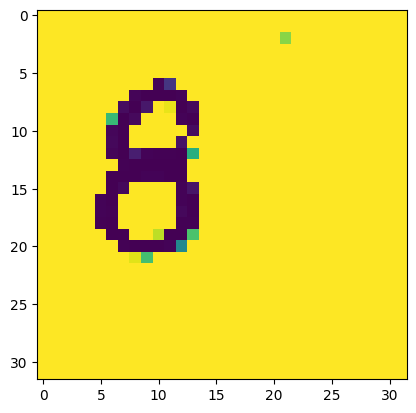

In [ ]:
index = 13
plt.imshow(image[index].permute(1,2,0))
label[index]

## Flow Matching Model For MNIST **(Guided & Unguided)**

![Model architecture](../model_architecture.png)

In [44]:
class EmbeddingLayer(nn.Module):
    def __init__(self, in_dim:int=1, h_dim:int=40):
        super().__init__()
        assert h_dim % 2 == 0, "h_dim must be divided by zero"
        self.in_dim = in_dim
        self.half_dim = h_dim // 2

        self.w = nn.Parameter(torch.rand(1, self.half_dim))
    
    def forward(self, t:torch.tensor):
        """
        Args:
            t: dim(bs, 1) -> dim(bs, time)
        Returns:
            t_embed: dim(bs, h_dim)
        """
        freqs = t @ self.w
        sin_embeds = torch.sin(2 * torch.pi * freqs)
        cos_embeds = torch.cos(2 * torch.pi * freqs)
        return torch.cat([sin_embeds, cos_embeds], dim=-1) * math.sqrt(2)
        # embeddings = torch.zeros(t.shape[0], self.half_dim*2, device=t.device)
        # embeddings[:, 0::2] = sin_embeds
        # embeddings[:, 1::2] = cos_embeds
        # return embeddings

In [45]:
class ResidualLayer(nn.Module):
    def __init__(self, channel:int, mlp_dim:int):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.SiLU(),
            nn.BatchNorm2d(channel),
            nn.Conv2d(channel, channel, kernel_size=3, padding=1)
        )
        self.layer2 = nn.Sequential(
            nn.SiLU(),
            nn.BatchNorm2d(channel),
            nn.Conv2d(channel, channel, kernel_size=3, padding=1)
        )
        self.MLP = nn.Sequential(
            nn.Linear(mlp_dim, mlp_dim),
            nn.SiLU(),
            nn.Linear(mlp_dim, channel)
        )

    def forward(self, x:torch.tensor, t:torch.tensor, label:torch.tensor):
        residual = x.clone()
        t = self.MLP(t).unsqueeze(-1).unsqueeze(-1)
        label = self.MLP(label).unsqueeze(-1).unsqueeze(-1)
        x = self.layer1(x) + t + label
        x = self.layer2(x) + residual
        return x


In [46]:
class DownSampleLayer(nn.Module):
    def __init__(self, in_channel:int, out_channel:int):
        super().__init__()

        self.layer = nn.Conv2d(in_channel, out_channel, kernel_size=3, stride=2, padding=1)

    def forward(self, x:torch.tensor):
        return self.layer(x)
    
class UpSampleLayer(nn.Module):
    def __init__(self, in_channel:int, out_channel:int):
        super().__init__()

        self.layer = nn.Sequential(nn.Upsample(scale_factor=2, mode='bilinear'), nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1))

    def forward(self, x:torch.tensor):
        return self.layer(x)

In [47]:
class Encoder(nn.Module):
    def __init__(self, in_channel:int, out_channel:int, mlp_dim:int):
        super().__init__()
        
        self.res_layers = nn.ModuleList([
            ResidualLayer(in_channel, mlp_dim) for _ in range(2)
        ])

        self.down_sample = DownSampleLayer(in_channel, out_channel)

    def forward(self, x:torch.tensor, t:torch.tensor, label:torch.tensor):
        for layer in self.res_layers:
            x = layer(x, t, label)
        return self.down_sample(x)
    
class Decoder(nn.Module):
    def __init__(self, in_channel:int, out_channel:int, mlp_dim:int):
        super().__init__()

        self.res_layers = nn.ModuleList([
            ResidualLayer(out_channel, mlp_dim) for _ in range(2)
        ])

        self.up_sample = UpSampleLayer(in_channel, out_channel)

    def forward(self, x:torch.tensor, t:torch.tensor, label:torch.tensor):
        x = self.up_sample(x)
        for layer in self.res_layers:
            x = layer(x, t, label)
        return x
    

class Midcoder(nn.Module):
    def __init__(self, channels:int, mlp_dim:int):
        super().__init__()
        self.layers = nn.ModuleList([
            ResidualLayer(channels, mlp_dim) for _ in range(2)
        ])
        
        self.attn = nn.MultiheadAttention(embed_dim=channels, num_heads=8, batch_first=True)


    def forward(self, x:torch.tensor, t:torch.tensor, label:torch.tensor):
        B, C, H, W = x.shape
        
        x = self.layers[0](x, t, label)
        x = x.flatten(2).permute(0, 2, 1)
        x, _ = self.attn(x, x, x)
        x = x.permute(0, 2, 1).view(B, C, H, W)
        x = self.layers[1](x, t, label)
        return x
    
        # for layer in self.layers:
        #     x = layer(x, t, label)
        # return x

In [48]:
class GuidedFlowMatching(nn.Module):
    def __init__(self, in_channel:int, embed_dim:int, guidance_scale:float):
        super().__init__()

        self.guidance_scale = guidance_scale
        self.channels = [32, 64, 128]
        self.init_conv = nn.Conv2d(in_channel, self.channels[0], kernel_size=3, padding=1)
        self.final_conv = nn.Conv2d(self.channels[0], in_channel, kernel_size=3, padding=1)

        self.time_embedding = EmbeddingLayer(h_dim=embed_dim)
        self.label_embedding = nn.Embedding(num_embeddings = 11, embedding_dim = embed_dim)
        
        self.encoders = nn.ModuleList([
            Encoder(ch1, ch2, embed_dim) for ch1, ch2 in zip(self.channels[:-1], self.channels[1:])
        ])
        self.decoders = nn.ModuleList([
            Decoder(ch1, ch2, embed_dim) for ch1, ch2 in zip(self.channels[::-1][:-1], self.channels[::-1][1:])
        ])
        self.bottle_neck = Midcoder(self.channels[-1], embed_dim)


    def forward(self, x:torch.tensor, t:torch.tensor, label:torch.tensor):
        intermediate_xt = []

        time_embed = self.time_embedding(t)
        label_embed = self.label_embedding(label)
        x_t = self.init_conv(x)

        for encoder in self.encoders:
            x_t = encoder(x_t, time_embed, label_embed)
            intermediate_xt.append(x_t.clone())
        
        x_t = self.bottle_neck(x_t, time_embed, label_embed)

        for decoder in self.decoders:
            x_t += intermediate_xt.pop()
            x_t = decoder(x_t, time_embed, label_embed)
        
        u_t = self.final_conv(x_t)
        return u_t
    
    
    def set_guidance_scale(self, guidance_scale:float):
        self.guidance_scale = guidance_scale
        
    
    def step(self, x_t:torch.tensor, label:torch.tensor, t:torch.tensor, dt:torch.tensor):
        y = torch.ones_like(label) * 10
        guided_ut = self(x_t, t, label)
        unguided_ut = self(x_t, t, y)
        u_t = (1 - self.guidance_scale) * unguided_ut + self.guidance_scale * guided_ut
        return x_t + u_t * dt
    
        # time_delta = dt/2
        # mid_u_t = self(x_t, t)
        # mid_x_t = x_t + mid_u_t * time_delta
        # u_t = self(mid_x_t, t+time_delta)
        # x_t = mid_x_t + u_t * time_delta
        # return x_t
        

    @torch.no_grad
    def sample(self, x_0:torch.tensor, label:torch.tensor, num_step:int):
        device = next(self.parameters()).device
        
        x_t = x_0
        x_t = x_t.to(device)
        label = label.to(device)
        time_steps = torch.linspace(0.0, 1.0, num_step).to(device)

        for i in range(len(time_steps)-1):
            dt = time_steps[i+1] - time_steps[i]
            t = torch.full((x_t.shape[0], 1), time_steps[i]).to(device)
            x_t = self.step(x_t, label, t, dt)
            
        return x_t
    
    # @torch.no_grad
    # def sample(self, x_0:torch.tensor, label:torch.tensor, num_step:int):
    #     self.prob_paths = []
    #     self.time = []
    #     device = next(self.parameters()).device
        
    #     x_t = x_0
    #     x_t = x_t.to(device)
    #     label = label.to(device)
    #     time_steps = torch.linspace(0.0, 1.0, num_step).to(device)
        
    #     self.prob_paths.append(x_0.squeeze(0).permute(1,2,0).detach().cpu().numpy())
    #     self.time.append(0.0)

    #     for i in range(len(time_steps)-1):
    #         dt = time_steps[i+1] - time_steps[i]
    #         t = torch.full((x_t.shape[0], 1), time_steps[i]).to(device)
    #         x_t = self.step(x_t, label, t, dt)
            
    #         vis_tensor = x_t.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
    #         self.prob_paths.append(vis_tensor)
    #         self.time.append(time_steps[i+1])
    #     return x_t

In [ ]:
# model = UnGuidedFlowMatching(1, 16)

# B, C, H, W = 10, 1, 256, 256
# dummy_img = torch.rand(B, C, H, W)
# dummy_time = torch.rand(B, 1)
# dummy_img.shape, dummy_time.shape

# model.eval()
# out = model(dummy_img, dummy_time)

### **Training Unguided**

In [49]:
class GuidedFlowMatchingLightning(pl.LightningModule):
    """PyTorch Lightning wrapper for training only"""
    def __init__(self, in_channel=1, embed_dim=40, lr=1e-3, eta:float=0.1):
        super().__init__()
        self.save_hyperparameters()
        
        self.lr = lr
        self.eta = eta
        
        # Use the pure PyTorch model
        self.model = GuidedFlowMatching(in_channel, embed_dim, guidance_scale=1)
        self.criterion = nn.MSELoss()


    def forward(self, x, t, label):
        return self.model(x, t, label)
    

    def training_step(self, batch, batch_idx):
        image, noise, x_t, t, label = batch
        mask = (torch.rand(label.shape[0]) < self.eta)
        label[mask] = 10
        # label = label.unsqueeze(dim=-1).type(torch.float32)
        
        out = self(x_t, t, label)
        loss = self.criterion(out, image - noise)
        
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss
    

    def on_train_epoch_end(self):
        avg_loss = self.trainer.callback_metrics.get('train_loss')
        self.log('train_loss_epoch', avg_loss)
        if avg_loss is not None:
            print(f"\nEpoch {self.current_epoch + 1}/{self.trainer.max_epochs} | "f"Average Train Loss: {avg_loss:.6f}")
        else:
            print(f"\nEpoch {self.current_epoch + 1}/{self.trainer.max_epochs} completed")
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=self.trainer.max_epochs,
            eta_min=1e-6
        )
        return {
            'optimizer': optimizer,
            # 'lr_scheduler': {
            #     'scheduler': scheduler,
            #     'interval': 'epoch'
            # }
        }
    
    def get_model(self):
        """Extract the pure PyTorch model for inference"""
        return self.model

In [50]:
checkpoint_callback = ModelCheckpoint(
    dirpath='../data/',
    filename=f'unguided_model_{{epoch}}',
    save_top_k=2,
    save_last=True,
    monitor='train_loss_epoch',
    mode='min'
)

class PrintCallback(Callback):
    def on_train_start(self, trainer, pl_module):
        print("Training started!")
    def on_train_end(self, trainer, pl_module):
        print("Training is done.")

In [51]:
model = GuidedFlowMatchingLightning(1, 40, 1e-3)

In [ ]:
height, width = 32, 32
file_path = '../data/Images(500x500)-001.npy'
label_path = '../data/WriterInfo.npy'
train_dataset = MNISTData(file_path, label_path, height, width)
dataloader = DataLoader(train_dataset, batch_size=125, shuffle=False)

### **Training Loop**

In [ ]:
trainer = pl.Trainer(
    max_epochs=5,
    accelerator='auto',
    devices=1,
    callbacks=[PrintCallback(), checkpoint_callback],
    # gradient_clip_val=1.0,
    # gradient_clip_algorithm="norm",
    # accumulate_grad_batches=1,
    # detect_anomaly=True,
    # limit_train_batches=5
)

In [ ]:
trainer.fit(model, train_dataloaders=dataloader)

## Sampling

In [ ]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(device)
# model = GuidedFlowMatchingLightning.load_from_checkpoint("../data/last.ckpt")
flow_model = model.get_model()
flow_model.set_guidance_scale(3.0)

In [ ]:
num_steps = 30
height, width = 32, 32
Row, Col = 3, 5

y = 5
x_0 = torch.randn(Row*Col, 1, height, width)
label = torch.ones(Row*Col, dtype=torch.int64) * y
x_1 = flow_model.sample(x_0, label, num_steps)

fig, axes = plt.subplots(Row, Col, figsize=(10, 8))

for i in range(Row*Col):
    row = i // Col
    col = i % Col
    axes[row, col].imshow(x_1[i].permute(1,2,0).detach().cpu().numpy())
    axes[row, col].set_title(f"Label : {str(y)}")
    axes[row, col].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# num_steps = 20
# height, width = 64, 64

# y = 1.0
# x_0 = torch.randn(1, 1, height, width)
# label = torch.tensor([[y]])
# x_1 = flow_model.sample(x_0, label, num_steps)

# Row, Col = 3, 3
# fig, axes = plt.subplots(Row, Col, figsize=(10, 8))
# indexes = torch.linspace(0, num_steps-1, Row*Col, dtype=torch.int32)

# for i in range(len(indexes)):
#     row = i // Col  # Fixed: divide by number of columns
#     col = i % Col
#     index = indexes[i].item()  # Fixed: convert tensor to Python int
#     axes[row, col].imshow(flow_model.prob_paths[index])
#     axes[row, col].grid(True)
#     axes[row, col].set_title(f"Time Step {flow_model.time[index]:.3f}")  # Fixed: format float

# plt.tight_layout()
# plt.show()

## **DiT** (Diffusion Transformer)

In [ ]:
# class LayerNormalization(nn.Module):
#     def __init__(self, epsilon:float = 1e-6):
#         super().__init__()
#         self.epsilon = epsilon
#         self.alpha = nn.Parameter(torch.ones(1))
#         self.beta = nn.Parameter(torch.ones(1))
        
#     def forward(self, x:torch.tensor):
#         mean = torch.mean(x, dim=-1, keepdim=True)
#         std = torch.mean(x, dim=-1, keepdim=True)
        
#         return self.alpha * (x - mean) / (std + self.epsilon) + self.beta
    

In [ ]:
# import torch
# import torch.nn as nn

# class AdaLNZeroDiTBlock(nn.Module):
#     def __init__(self, hidden_size, num_heads, cond_dim):
#         super().__init__()
        
#         # Standard transformer components
#         self.norm1 = nn.LayerNorm(hidden_size, elementwise_affine=False)  # No learnable γ, β
#         self.attn = nn.MultiheadAttention(hidden_size, num_heads, batch_first=True)
#         self.norm2 = nn.LayerNorm(hidden_size, elementwise_affine=False)
#         self.ffn = nn.Sequential(
#             nn.Linear(hidden_size, hidden_size * 4),
#             nn.GELU(),
#             nn.Linear(hidden_size * 4, hidden_size)
#         )
        
#         # MLP to produce 6 modulation parameters from conditioning
#         self.adaLN_modulation = nn.Sequential(
#             nn.SiLU(),
#             nn.Linear(cond_dim, 6 * hidden_size)  # Outputs: γ₁, β₁, α₁, γ₂, β₂, α₂
#         )
        
#         # Initialize α₁, α₂ to zero (the "Zero" in adaLN-Zero)
#         nn.init.zeros_(self.adaLN_modulation[-1].weight)
#         nn.init.zeros_(self.adaLN_modulation[-1].bias)
    
#     def forward(self, x, c):
#         """
#         x: (B, N, D) - input tokens
#         c: (B, cond_dim) - conditioning (timestep + label embedding)
#         """
#         # Get modulation parameters from conditioning
#         modulation = self.adaLN_modulation(c)  # (B, 6*D)
#         γ1, β1, α1, γ2, β2, α2 = modulation.chunk(6, dim=-1)  # Each: (B, D)
        
#         # Reshape for broadcasting: (B, D) → (B, 1, D)
#         γ1 = γ1.unsqueeze(1)
#         β1 = β1.unsqueeze(1)
#         α1 = α1.unsqueeze(1)
#         γ2 = γ2.unsqueeze(1)
#         β2 = β2.unsqueeze(1)
#         α2 = α2.unsqueeze(1)
        
#         # --- Attention Block ---
#         # Adaptive LayerNorm: scale and shift with γ₁, β₁
#         h = self.norm1(x)
#         h = h * (1 + γ1) + β1  # Scale and shift
        
#         # Self-attention
#         attn_out, _ = self.attn(h, h, h)
        
#         # Scale attention output by α₁ and add residual
#         x = x + α1 * attn_out
        
#         # --- FFN Block ---
#         # Adaptive LayerNorm: scale and shift with γ₂, β₂
#         h = self.norm2(x)
#         h = h * (1 + γ2) + β2  # Scale and shift
        
#         # Feedforward
#         ffn_out = self.ffn(h)
        
#         # Scale FFN output by α₂ and add residual
#         x = x + α2 * ffn_out
        
#         return x


# # Example usage
# B, N, D = 4, 256, 512  # batch, num_patches, hidden_dim
# cond_dim = 256

# block = AdaLNZeroDiTBlock(hidden_size=D, num_heads=8, cond_dim=cond_dim)

# # Input
# x = torch.randn(B, N, D)           # Image patches
# c = torch.randn(B, cond_dim)       # Conditioning (t + y embedded)

# # Forward
# out = block(x, c)
# print(out.shape)  # (4, 256, 512)